In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../utils/')
import src_utils
import seaborn as sns

In [54]:
pal = sns.color_palette('RdBu_r')


[(0.1843137254901961, 0.47266435986159167, 0.7116493656286044),
 (0.5300269127258745, 0.7456362937331795, 0.8560553633217992),
 (0.8605151864667435, 0.9174163783160323, 0.9487120338331411),
 (0.9856978085351787, 0.888965782391388, 0.8320645905420994),
 (0.9407151095732412, 0.6099192618223763, 0.4812764321414842),
 (0.7561707035755478, 0.21038062283737025, 0.22352941176470587)]

# 1. Import data

In [2]:
resid_df = pd.read_csv('../../utils/residuals.csv', index_col=0)
diffsel_df = pd.read_csv('../../utils/diffsel.csv', index_col=0)
master_df = pd.read_csv('../../utils/point_muts.csv', index_col=0, header=[0,1])

# 2. Parse data into numpy arrays

In [3]:
resids = resid_df['raw_resids'].values
diffsel = diffsel_df['envision_scaled_diffsel'].values
dmso_scores = master_df.loc[:, ('Zero', 'score')].values
rad_scores = master_df.loc[:, ('Radicicol', 'score')].values

# 3. Define clients via stdev

In [4]:
resid_std = np.nanstd(resids)
resid_mean = np.nanmean(resids)

# 4. Read in heatmaps

In [5]:
resid_map = pd.read_csv('../heatmaps/raw_resid_heatmap.csv', index_col=0)

# 5. Create masks

In [6]:
upper1 = resid_mean + resid_std 
lower1 = resid_mean - resid_std
thresh1_pos = resid_map.values > upper1
thresh1_neg = resid_map.values < lower1
thresh1 = thresh1_pos | thresh1_neg

upper2 = resid_mean + 2 * resid_std 
lower2 = resid_mean - 2 * resid_std
thresh2_pos = resid_map.values > upper2
thresh2_neg = resid_map.values < lower2
thresh2 = thresh2_pos | thresh2_neg

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


## 5a. Save masks to define clients later 

In [225]:
# Save clients
np.savetxt('../../utils/analysis_utils/client_mask.csv', X=(thresh1 * 1).astype(int))

# Save strong clients
np.savetxt('../../utils/analysis_utils/strong_client_mask.csv', X=(thresh2 * 1).astype(int))

# Save inhibited and dependent clients
np.savetxt('../../utils/analysis_utils/inhibited_clients.csv', X=(thresh1_pos * 1).astype(int))
np.savetxt('../../utils/analysis_utils/dependent_clients.csv', X=(thresh1_neg * 1).astype(int))

In [220]:
client_mask = np.loadtxt('../../utils/analysis_utils/client_mask.csv').astype(bool)

# 6. Look at heatmaps

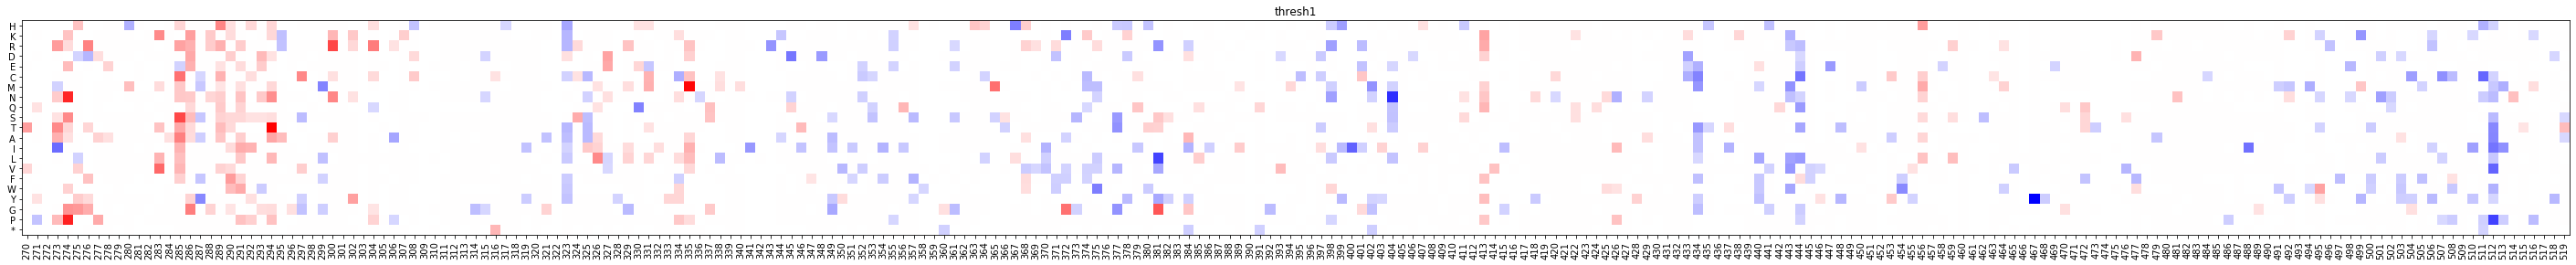

(<Figure size 3600x21600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12538f3d0>)

In [7]:
src_utils.plot_heatmap(resid_map.values * thresh1, 'thresh1')

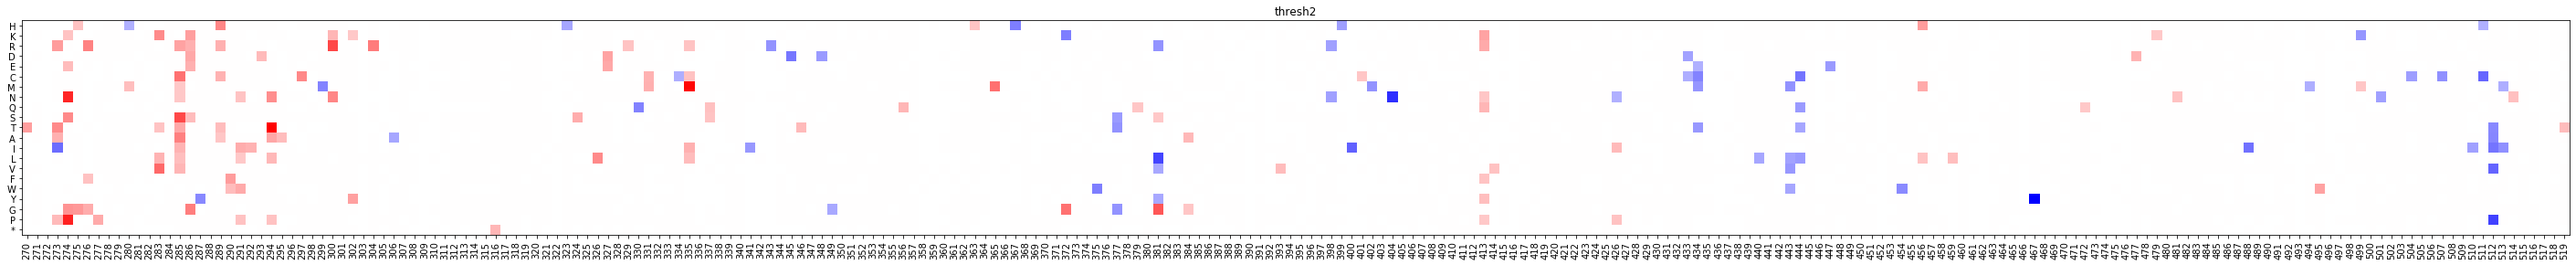

(<Figure size 3600x21600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123f3a490>)

In [8]:
src_utils.plot_heatmap(resid_map.values * thresh2, 'thresh2')

# 7. Count clients and number of dependent and inhibited

In [105]:
print('Total clients = {}'.format(str(len(resid_map.values[thresh1]))))
print('Total inhibited clients = {}'.format(str(len(resid_map.values[thresh1_pos]))))
print('Total dependent clients = {}'.format(str(len(resid_map.values[thresh1_neg]))))
print('\n')
print('Total strong clients = {}'.format(str(len(resid_map.values[thresh2]))))
print('Total strong inhibited clients = {}'.format(str(len(resid_map.values[thresh2_pos]))))
print('Total strong dependent clients = {}'.format(str(len(resid_map.values[thresh2_neg]))))

Total clients = 645
Total inhibited clients = 315
Total dependent clients = 330


Total strong clients = 178
Total strong inhibited clients = 114
Total strong dependent clients = 64


# 8. Create a windowed average of resid scores

In [10]:
def moving_average(a, n=10) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pos_resid_ave = resid_map.mean(axis=1, skipna=True).values
windowed_resids = moving_average(pos_resid_ave)

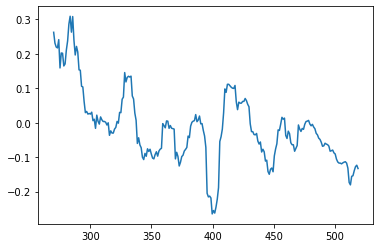

In [12]:
plt.plot(np.linspace(270, 519, num=len(windowed_resids)), windowed_resids)

# 9. Count clients by position

In [28]:
# Replace all 0.0's with NaNs
clients = resid_map.values * thresh1
clients[clients == 0.0] = np.nan
clients[clients == -0.0] = np.nan

client_by_pos = np.sum(~np.isnan(clients), axis=1)

Text(0.5, 1.0, 'Clients by position')

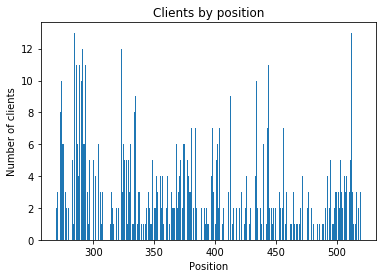

In [31]:
plt.bar(np.arange(270, 520), client_by_pos)
plt.xlabel('Position')
plt.ylabel('Number of clients')
plt.title('Clients by position')

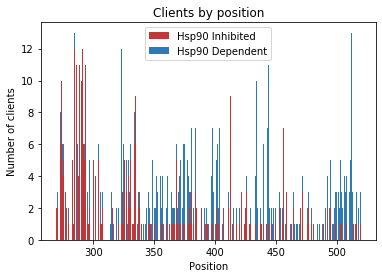

In [58]:
# Color by type of client
ihb_clients = resid_map.values * thresh1_pos
dep_clients = resid_map.values * thresh1_neg

ihb_clients[ihb_clients == 0.0] = np.nan
ihb_clients[ihb_clients == -0.0] = np.nan
dep_clients[dep_clients == 0.0] = np.nan
dep_clients[dep_clients == -0.0] = np.nan

ihb_clients_by_pos = np.sum(~np.isnan(ihb_clients), axis=1)
dep_clients_by_pos = np.sum(~np.isnan(dep_clients), axis=1)

pos = np.arange(270, 520)

# Plot stacked bar
p1 = plt.bar(pos, ihb_clients_by_pos, label='Hsp90 Inhibited', color=pal[-1])
p2 = plt.bar(pos, dep_clients_by_pos, bottom=ihb_clients_by_pos, label='Hsp90 Dependent', color=pal[0])
plt.xlabel('Position')
plt.ylabel('Number of clients')
plt.title('Clients by position')
plt.legend()
plt.show()

In [75]:
# Calculate number of mutations per position
total_mutants_by_pos = np.sum(~np.isnan(resid_map.values), axis=1)
n_lobe_mutants = sum(total_mutants_by_pos[:71])
c_lobe_mutants = sum(total_mutants_by_pos[71:])

n_lobe_clients = sum(client_by_pos[:71])
c_lobe_clients = sum(client_by_pos[71:])

In [79]:
print('Percent of mutations in N lobe that are clients: {}'.format(n_lobe_clients / n_lobe_mutants))
print('Percent of mutations in C lobe that are clients: {}'.format(c_lobe_clients / c_lobe_mutants))

Percent of mutations in N lobe that are clients: 0.24664107485604606
Percent of mutations in C lobe that are clients: 0.15791615791615793


In [80]:
# Calculate percent of clients in each lobe that are inhibited vs dependent
ihb_n_lobe_clients = sum(ihb_clients_by_pos[:71])
ihb_c_lobe_clients = sum(ihb_clients_by_pos[71:])

perc_ihb_n = ihb_n_lobe_clients / n_lobe_clients
perc_ihb_c = ihb_c_lobe_clients / c_lobe_clients

print('Percent of N-lobe clients that are inhibited = {}'.format(perc_ihb_n))
print('Percent of N-lobe clients that are dependent = {}'.format(1 - perc_ihb_n))
print('Percent of C-lobe clients that are inhibited = {}'.format(perc_ihb_c))
print('Percent of C-lobe clients that are dependent = {}'.format(1 - perc_ihb_c))

Percent of N-lobe clients that are inhibited = 0.7587548638132295
Percent of N-lobe clients that are dependent = 0.24124513618677046
Percent of C-lobe clients that are inhibited = 0.30927835051546393
Percent of C-lobe clients that are dependent = 0.6907216494845361


In [97]:
# Types of mutants in clients
client_muts = np.sum(~np.isnan(clients), axis=0)
total_muts = np.sum(~np.isnan(resid_map.values), axis=0)

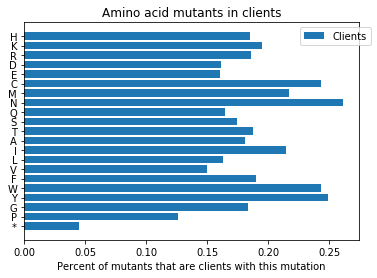

In [145]:
inv_aa_idx_dict = inv_map = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

fig, ax = plt.subplots()
# Example data
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

#ax.barh(y_pos, total_muts, align='center', label='Total mutants')
ax.barh(y_pos, client_muts / total_muts, align='center', label='Clients')
ax.set_yticks(y_pos)
ax.set_yticklabels(tick_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent of mutants that are clients with this mutation')
ax.set_title('Amino acid mutants in clients')
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

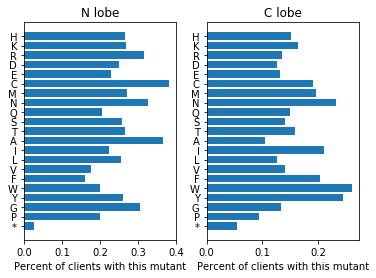

In [154]:
ihb_clients_by_mut = np.sum(~np.isnan(ihb_clients), axis=0)
dep_clients_by_mut = np.sum(~np.isnan(dep_clients), axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
# Example data
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

#ax[0].barh(y_pos, total_muts, align='center', label='Total mutants')
ax[0].barh(y_pos, np.sum(~np.isnan(clients[:70, :]), axis=0) / np.sum(~np.isnan(resid_map.values[:70, :]), axis=0), align='center', label='Clients')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(tick_labels)
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('Percent of clients with this mutant')
ax[0].set_title('N lobe')
#plt.legend(bbox_to_anchor=(1.05, 1.0))

ax[1].barh(y_pos, np.sum(~np.isnan(clients[70:, :]), axis=0) / np.sum(~np.isnan(resid_map.values[70:, :]), axis=0), align='center', label='Clients')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(tick_labels)
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_xlabel('Percent of clients with this mutant')
ax[1].set_title('C lobe')
plt.show()

In [ ]:
# Look at amino acid mutations by lobe

fig, ax = plt.subplots(nrows=1, ncols=2)
# Example data
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

ax[0].barh(y_pos, total_muts, align='center', label='Total mutants')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(tick_labels)
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('Number of clients with this mutant')
ax[0].set_title('Inhibited clients')
#plt.legend(bbox_to_anchor=(1.05, 1.0))

ax[0].barh(y_pos, total_muts, align='center', label='Total mutants')
ax[1].barh(y_pos, dep_clients_by_mut, align='center', label='Clients')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(tick_labels)
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_xlabel('Number of clients with this mutant')
ax[1].set_title('Dependent clients')
plt.show()

In [110]:
clients.shape


(250, 21)

In [124]:
tick_label_arr = np.array(list(tick_labels))
tick_label_arr = np.expand_dims(tick_label_arr, axis=0)
tick_label_arr = np.repeat(tick_label_arr, repeats=clients.shape[0], axis=0)

Text(0.5, 1.0, 'Residual scores for clients')

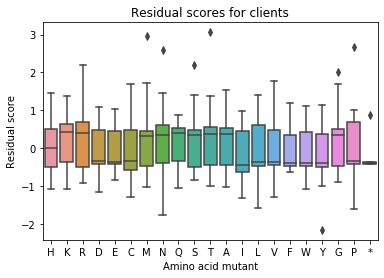

In [157]:
# Dot plots of effect of each mutation
sns.boxplot(x=np.ndarray.flatten(tick_label_arr), y=np.ndarray.flatten(clients))
plt.xlabel('Amino acid mutant')
plt.ylabel('Residual score')
plt.title('Residual scores for clients')

In [159]:
ihb_clients.shape

(250, 21)

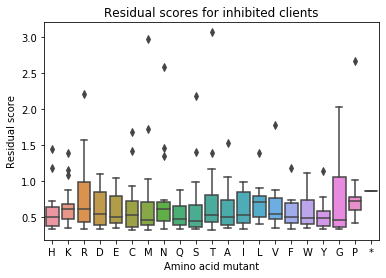

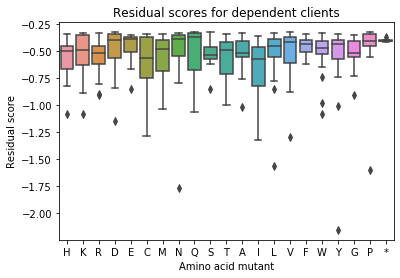

In [164]:
# Dot plots for inhibited/dependent clients
tick_label_arr = np.array(list(tick_labels))
tick_label_arr = np.expand_dims(tick_label_arr, axis=0)
tick_label_arr = np.repeat(tick_label_arr, repeats=ihb_clients.shape[0], axis=0)

sns.boxplot(x=np.ndarray.flatten(tick_label_arr), y=np.ndarray.flatten(ihb_clients))
plt.xlabel('Amino acid mutant')
plt.ylabel('Residual score')
plt.title('Residual scores for inhibited clients')
plt.show()

tick_label_arr = np.array(list(tick_labels))
tick_label_arr = np.expand_dims(tick_label_arr, axis=0)
tick_label_arr = np.repeat(tick_label_arr, repeats=dep_clients.shape[0], axis=0)

sns.boxplot(x=np.ndarray.flatten(tick_label_arr), y=np.ndarray.flatten(dep_clients))
plt.xlabel('Amino acid mutant')
plt.ylabel('Residual score')
plt.title('Residual scores for dependent clients')
plt.show()

In [183]:
# Look at positions of amino acids that are highly represented in clients
inv_pos_idx_dict = inv_map = {v: k for k, v in src_utils.__pos_idx_dict__.items()}

# Inhibited mutants
r_clients = clients[:, src_utils.__aa_idx_dict__['R']]
g_clients = clients[:, src_utils.__aa_idx_dict__['G']]

r_client_pos = list(np.argwhere(~np.isnan(r_clients)).flatten())
g_client_pos = list(np.argwhere(~np.isnan(g_clients)).flatten())

# Dependent mutants
c_clients = clients[:, src_utils.__aa_idx_dict__['C']]
i_clients = clients[:, src_utils.__aa_idx_dict__['I']]

c_client_pos = list(np.argwhere(~np.isnan(c_clients)).flatten())
i_client_pos = list(np.argwhere(~np.isnan(i_clients)).flatten())


'+'.join([str(inv_pos_idx_dict[x]) for x in i_client_pos])


'273+285+290+291+292+319+323+325+326+329+332+335+341+346+349+351+354+356+370+379+384+386+389+397+399+400+401+403+407+415+426+434+437+450+488+506+510+512+513'